# Customer Segmentation with K-Means Algorithm

# Business Problem 


An e-commerce company wants to segment its customers and determine marketing strategies according to these segments.

For this, we will define the behavior of customers and create groups according to the clusters in these behaviors.

In other words, we will take those who exhibit common behaviors into the same groups and we will try to develop sales and marketing specific techniques to these groups.


### **Data Set Information**

This Online Retail II data set contains all the transactions occurring for a UK-based and registered, non-store online retail between 01/12/2009 and 09/12/2011.The company mainly sells unique all-occasion gift-ware. Many customers of the company are wholesalers.

### **Attribute Information**

- **InvoiceNo**: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.
- **StockCode**: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.
- **Description**: Product (item) name. Nominal.
- **Quantity**: The quantities of each product (item) per transaction. Numeric.
- **InvoiceDate**: Invice date and time. Numeric. The day and time when a transaction was generated.
- **UnitPrice**: Unit price. Numeric. Product price per unit in sterling (Â£).
- **CustomerID**: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.
- **Country**: Country name. Nominal. The name of the country where a customer resides.

In [3]:
#installation of libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans

#to display all columns and rows:
pd.set_option('display.max_columns', None); pd.set_option('display.max_rows', None);

#we determined how many numbers to show after comma
pd.set_option('display.float_format', lambda x: '%.0f' % x)
import matplotlib.pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

In [7]:
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle
#Check the present working directory using pwd command

/content/gdrive/My Drive/Kaggle


In [10]:
! kaggle datasets download -d mashlyn/online-retail-ii-uci

 34% 5.00M/14.5M [00:00<00:00, 47.0MB/s]
100% 14.5M/14.5M [00:00<00:00, 70.9MB/s]


In [11]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

Archive:  india-headlines-news-dataset.zip
replace india-news-headlines.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: india-news-headlines.csv  

Archive:  online-retail-ii-uci.zip
  inflating: online_retail_II.csv    y


2 archives were successfully processed.


In [12]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [14]:
# https://drive.google.com/file/d/1-00_RK03LFOAknNs0vG9IuXpg6zDG0KU/view?usp=sharing
fileDownloaded = drive.CreateFile({'id':'1-00_RK03LFOAknNs0vG9IuXpg6zDG0KU'})

In [15]:
fileDownloaded.GetContentFile('online_retail.csv')

In [42]:
#calling the dataset
df = pd.read_csv('online_retail.csv', delimiter=',' )

# Data Understanding

In [43]:
#selection of the first 5 observations
df.head() 

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,7,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,7,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,7,13085,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1,13085,United Kingdom


In [45]:
#ranking of the most ordered products
df.groupby('Description').agg({"Quantity":"sum"}).sort_values("Quantity", ascending = False).head()

,Quantity
Description,
WORLD WAR 2 GLIDERS ASSTD DESIGNS,108545
WHITE HANGING HEART T-LIGHT HOLDER,93050
ASSORTED COLOUR BIRD ORNAMENT,81306
JUMBO BAG RED RETROSPOT,78090
BROCADE RING PURSE,70700


In [46]:
df.columns = df.columns.str.strip()#how many invoices are there in the data set
df["Invoice"].nunique()

53628

In [47]:
#which are the most expensive products
df.sort_values("Price", ascending = False).head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
748142,C556445,M,Manual,-1,2011-06-10 15:31:00,38970,15098,United Kingdom
241827,512771,M,Manual,1,2010-06-17 16:53:00,25111,nan,United Kingdom
241824,C512770,M,Manual,-1,2010-06-17 16:52:00,25111,17399,United Kingdom
320581,C520667,BANK CHARGES,Bank Charges,-1,2010-08-27 13:42:00,18911,nan,United Kingdom
1050063,C580605,AMAZONFEE,AMAZON FEE,-1,2011-12-05 11:36:00,17836,nan,United Kingdom


In [48]:
#top 5 countries with the highest number of orders
df["Country"].value_counts().head()

United Kingdom    981330
EIRE               17866
Germany            17624
France             14330
Netherlands         5140
Name: Country, dtype: int64

In [49]:
#total spending was added as a column
df['TotalPrice'] = df['Price']*df['Quantity']

In [50]:
#which countries did we get the most income from
df.groupby("Country").agg({"TotalPrice":"sum"}).sort_values("TotalPrice", ascending = False).head()

,TotalPrice
Country,
United Kingdom,16382584
EIRE,615520
Netherlands,548525
Germany,417989
France,328192


# Data Preparation

In [51]:
#oldest shopping date
df["InvoiceDate"].min() 

'2009-12-01 07:45:00'

In [52]:
#newest shopping date
df["InvoiceDate"].max() 

'2011-12-09 12:50:00'

In [53]:
#to make the assessment easier, today's date is set as January 1, 2012.  
today = pd.datetime(2012,1,1) 
today

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


datetime.datetime(2012, 1, 1, 0, 0)

In [54]:
#changing the data type of the order date
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [55]:
#taking values greater than 0, this will be easier in terms of evaluation
df = df[df['Quantity'] > 0]
df = df[df['TotalPrice'] > 0]

In [56]:
#removal of observation units with missing data from df
df.dropna(inplace = True) 

In [57]:
#check for missing values in the dataset
df.isnull().sum(axis=0)

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
TotalPrice     0
dtype: int64

In [58]:
#size information
df.shape 

(805549, 9)

In [59]:
df.describe([0.01,0.05,0.10,0.25,0.50,0.75,0.90,0.95, 0.99]).T
#explanatory statistics values of the observation units corresponding to the specified percentages
#processing according to numerical variables

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
Quantity,805549,13,144,1,1,1,1,2,5,12,24,36,128,80995
Price,805549,3,29,0,0,0,1,1,2,4,7,8,15,10954
Customer ID,805549,15332,1697,12346,12422,12681,12979,13982,15271,16805,17716,17913,18204,18287
TotalPrice,805549,22,224,0,1,1,2,5,12,20,35,68,202,168470


In [60]:
#customer distribution by country
country_cust_data=df[['Country','Customer ID']].drop_duplicates()
country_cust_data.groupby(['Country'])['Customer ID'].aggregate('count').reset_index().sort_values('Customer ID', ascending=False)

,Country,Customer ID
38,United Kingdom,5350
14,Germany,107
13,France,95
32,Spain,41
3,Belgium,29
28,Portugal,24
24,Netherlands,22
34,Switzerland,22
33,Sweden,19
18,Italy,17


In [61]:
#keep only United Kingdom data
df_uk = df.query("Country=='United Kingdom'").reset_index(drop=True)
df_uk.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,7,13085,United Kingdom,83
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,7,13085,United Kingdom,81
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,7,13085,United Kingdom,81
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2,13085,United Kingdom,101
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1,13085,United Kingdom,30


# Finding RFM Values

RFM consists of Recency, Frequency, Monetary initials of expressions.

It is a technique that helps determine marketing and sales strategies based on buying habits of customers.

- **Recency**: Time since customer last purchase

- **Frequency**: Total number of purchases

- **Monetary**: Total spending by the customer

In [62]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,7,13085,United Kingdom,83
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,7,13085,United Kingdom,81
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,7,13085,United Kingdom,81
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2,13085,United Kingdom,101
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1,13085,United Kingdom,30


In [63]:
df.info() 
#dataframe's index dtype and column dtypes, non-null values and memory usage information

<class 'pandas.core.frame.DataFrame'>
Int64Index: 805549 entries, 0 to 1067370
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      805549 non-null  object        
 1   StockCode    805549 non-null  object        
 2   Description  805549 non-null  object        
 3   Quantity     805549 non-null  int64         
 4   InvoiceDate  805549 non-null  datetime64[ns]
 5   Price        805549 non-null  float64       
 6   Customer ID  805549 non-null  float64       
 7   Country      805549 non-null  object        
 8   TotalPrice   805549 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 61.5+ MB


In [64]:
#finding Recency and Monetary values.
df_x = df.groupby('Customer ID').agg({'TotalPrice': lambda x: x.sum(), #monetary value
                                        'InvoiceDate': lambda x: (today - x.max()).days}) #recency value
#x.max()).days; last shopping date of customers

In [65]:
df_y = df.groupby(['Customer ID','Invoice']).agg({'TotalPrice': lambda x: x.sum()})
df_z = df_y.groupby('Customer ID').agg({'TotalPrice': lambda x: len(x)}) 
#finding the frequency value per capita

In [66]:
#creating the RFM table
rfm_table= pd.merge(df_x,df_z, on='Customer ID')

In [67]:
#determination of column names
rfm_table.rename(columns= {'InvoiceDate': 'Recency',
                          'TotalPrice_y': 'Frequency',
                          'TotalPrice_x': 'Monetary'}, inplace= True)

In [68]:
rfm_table.head()

,Monetary,Recency,Frequency
Customer ID,,,
12346,77556,347,12
12347,5633,24,8
12348,2019,97,5
12349,4429,40,4
12350,334,332,1


# K-Means Segmentation

It is one of the unsupervised learning algorithms. The process is to separate the data according to its specific features and to reveal its characteristic features. Purpose is minimizing the sum of distance between points and maximizing the distance between clusters. This process is clustering.

Where is clustering used?

    - Clustering of products according to the customer groups who bought them
    - Clustering of documents, web searches according to similar words used
    - Customer segmentation
    - Grouping similar genes in the field of bioinformatics 
    
The K-means algorithm is a non-hierarchical, center-based algorithm.

K-means Clustering working principle;

This process continues until the average distance within a cluster minimizes and maximizes the distance with other clusters. The process begins with the random selection of k centers. The average distance from the center of all points in the cluster is then used to update the position of the centroids (centers). These steps are repeated by fixing the values of the centroids (centers).

This process continues until the average distance within a cluster minimizes and maximizes the distance with other clusters.

Our aim is to minimize the sum of distances within the cluster and to maximize the sum of distances between clusters. In other words, forming clusters that are more discrete from each other.

Two metrics can be used here.

   - Inertia: shows how far points in a cluster are. Therefore, a small inertia is targeted. Inertia value starts at zero and increases. (min SSE)
    
   - Silhoutte Score: shows how far data points in one cluster are from data points in another cluster. The score range is between -1 and 1, and it is expected to approach 1.
    
Inertia was used in this study.

In this study, we will segment the rfm metrics that we previously determined with k-means. We cannot apply the cluster operation to our data set in this state. We need numerical variables to do this. These variables are currently not available. We will apply cluster operation over rfm metric values with k-means.

## Visualization of Recency, Frequency and Monetary Values

In [69]:
#descriptive statistics for Recency
rfm_table.Recency.describe()

count   5878
mean     223
std      209
min       22
25%       47
50%      117
75%      401
max      760
Name: Recency, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


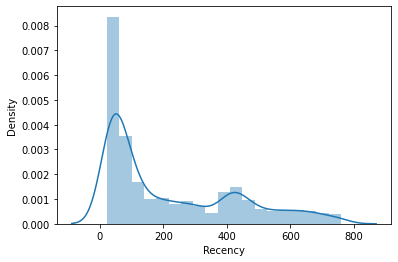

In [70]:
#Recency distribution plot
import seaborn as sns
x = rfm_table['Recency']

ax = sns.distplot(x)

In [71]:
#descriptive statistics for Frequency
rfm_table.Frequency.describe()

count   5878
mean       6
std       13
min        1
25%        1
50%        3
75%        7
max      398
Name: Frequency, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


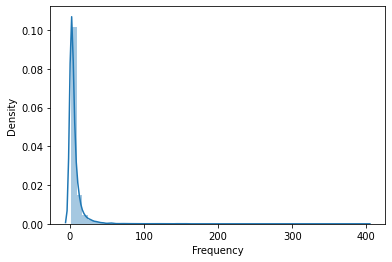

In [72]:
#Frequency distribution plot, taking observations which have frequency less than 1000
import seaborn as sns
x = rfm_table.query('Frequency < 1000')['Frequency']

ax = sns.distplot(x)

In [73]:
#descriptive statistics for Monetary
rfm_table.Monetary.describe()

count     5878
mean      3019
std      14738
min          3
25%        349
50%        899
75%       2307
max     608822
Name: Monetary, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


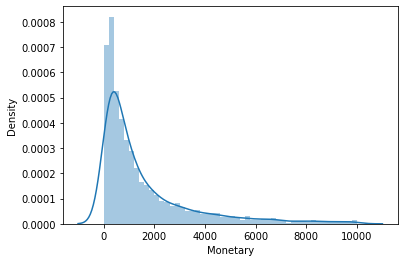

In [74]:
#Monateray distribution plot, taking observations which have monetary value less than 10000
import seaborn as sns
x = rfm_table.query('Monetary < 10000')['Monetary']

ax = sns.distplot(x)

In [75]:
#Split into four segments using quantiles
quantiles = rfm_table.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

In [76]:
quantiles

{'Frequency': {0.25: 1.0, 0.5: 3.0, 0.75: 7.0},
 'Monetary': {0.25: 348.76249999999993, 0.5: 898.915, 0.75: 2307.09},
 'Recency': {0.25: 47.0, 0.5: 117.0, 0.75: 401.0}}

In [77]:
#conversion process
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler((0,1))
x_scaled = min_max_scaler.fit_transform(rfm_table)
data_scaled = pd.DataFrame(x_scaled)

In [78]:
df[0:10]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,7,13085,United Kingdom,83
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,7,13085,United Kingdom,81
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,7,13085,United Kingdom,81
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2,13085,United Kingdom,101
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1,13085,United Kingdom,30
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,2,13085,United Kingdom,40
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1,13085,United Kingdom,30
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,6,13085,United Kingdom,60
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,3,13085,United Kingdom,31
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,4,13085,United Kingdom,45


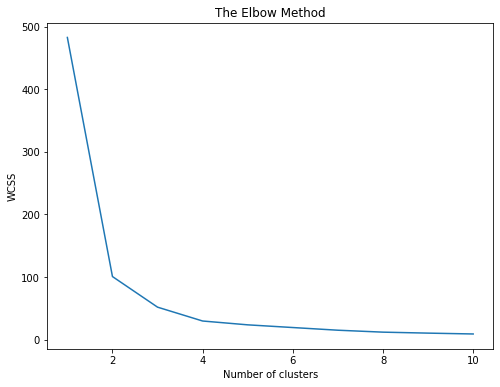

In [79]:
plt.figure(figsize=(8,6))
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',n_init=10, max_iter = 300)
    kmeans.fit(data_scaled)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

The important thing here is to determine the correct number of clusters. For this, we apply the Elbow Method.

Here, as the number of clusters increases, we use the part we call elbow and see that the value does not decrease too much after a certain point. For this reason, using 3 or 4 may be more valuable for us.

In [80]:
kmeans = KMeans(n_clusters = 4, init='k-means++', n_init =10,max_iter = 300)
kmeans.fit(data_scaled)
cluster = kmeans.predict(data_scaled)
#init = 'k-means ++' this makes it work faster

In [81]:
d_frame = pd.DataFrame(rfm_table)
d_frame['cluster_no'] = cluster
d_frame['cluster_no'].value_counts() #the number of people per cluster (Custer ID number)

1    3144
0    1110
3     987
2     637
Name: cluster_no, dtype: int64

In [82]:
#RFM Table
rfm_table.head()

,Monetary,Recency,Frequency,cluster_no
Customer ID,,,,
12346,77556,347,12,0
12347,5633,24,8,1
12348,2019,97,5,1
12349,4429,40,4,1
12350,334,332,1,3


In [83]:
#cluster average values
d_frame.groupby('cluster_no').mean() 

,Monetary,Recency,Frequency
cluster_no,,,
0,1029,434,3
1,4710,59,9
2,619,644,2
3,1418,234,4


# Conclusion

We have singularized Customer IDs based on 3 variables over rfm metrics.

This data set was reduced to 4 sets on the basis of numerical variables when k-means was applied.

# Resources


https://www.youtube.com/watch?v=DowbzgtH0-0

https://www.youtube.com/watch?v=fdUofaT8gUw

